In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [35]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


# Multiple features

In [101]:
def generate_synthetic_fico_data(n=1000):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 100, n) - np.random.choice([0, 20, 50, 100], n, p=[0.7, 0.15, 0.1, 0.05])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 850 - np.random.gamma(2, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data)
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.35, 'Amounts Owed': 0.30, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)
    
    return df

# Generate the dataset
df = generate_synthetic_fico_data()
fico_df = df.copy()


In [102]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.1 * (x - 650)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] > np.random.rand(fico_df.shape[0])).astype(int)

In [103]:
fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,749.671415,706.411569,437,683,225.355004,630.693967,0.126684,0
1,686.173570,719.320818,569,713,736.921118,686.299107,0.974167,1
2,764.768854,797.272891,849,822,661.986420,782.599608,0.999998,1
3,832.302986,680.290205,695,731,485.116537,721.254760,0.999196,1
4,676.584663,816.627977,763,845,648.383035,745.581328,0.999929,1
5,626.586304,652.577607,749,765,824.186697,686.347158,0.974287,1
6,857.921282,764.920133,630,844,717.807315,780.429220,0.999998,1
7,776.743473,504.395331,552,790,649.655303,649.944345,0.498609,1
8,633.052561,764.917478,584,774,381.189291,654.162569,0.602587,1
9,704.256004,720.170964,573,600,669.606093,675.451500,0.927247,1


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import numpy as np

# Example dataset loading
# Assuming 'FICO Score' is not used as a feature directly in the model training
X = fico_df[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']]  # model features
y = fico_df['True Label']  # the target variable
fico_scores = fico_df['FICO Score']  # keeping FICO Score separate

# Splitting the dataset
X_train, X_test, y_train, y_test, fico_train, fico_test = train_test_split(X, y, fico_scores, test_size=0.2, random_state=42)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)


# Get the predicted probabilities for the test set
y_scores = model.predict_proba(X_test)[:, 1]

# Find the optimal threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
optimal_idx = np.argmax(tpr - 0.2*fpr)
optimal_threshold_probability = thresholds[optimal_idx]

# Map this probability back to the FICO score
fico_sorted = np.array(fico_test)[np.argsort(y_scores)]
threshold_index = int(len(fico_sorted) * optimal_threshold_probability)
score_at_threshold = fico_sorted[threshold_index]

print(f"Optimal Probability Threshold: {optimal_threshold_probability}")
print(f"Corresponding FICO Score Threshold: {score_at_threshold}")


Optimal Probability Threshold: 0.350118605784549
Corresponding FICO Score Threshold: 661.9044503792954


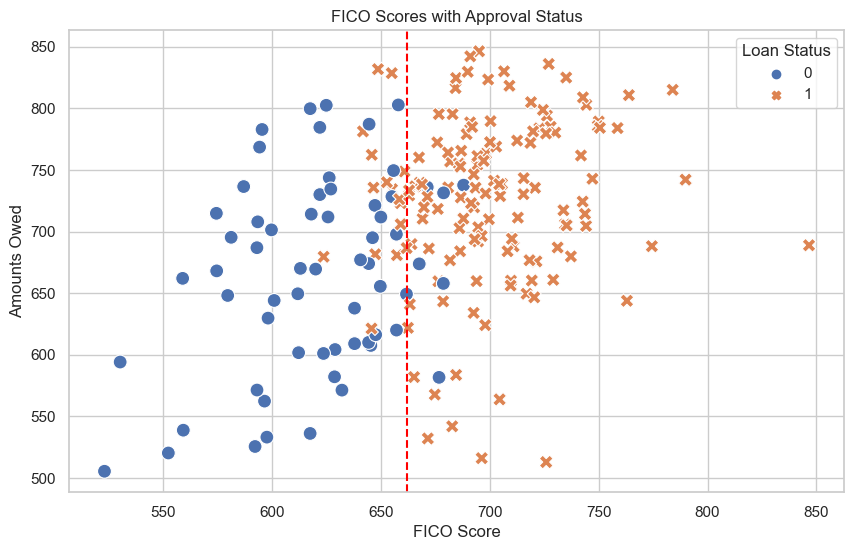

In [105]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fico_test, y=X_test['Amounts Owed'], hue=y_test, style=y_test, s=100)
plt.axvline(x=score_at_threshold, color='red', linestyle='--') # label=f'Threshold FICO Score: {score_at_threshold}
plt.title('FICO Scores with Approval Status')
plt.xlabel('FICO Score')
plt.ylabel('Amounts Owed')
plt.legend(title='Loan Status')
plt.show()

In [106]:
import cvxpy as cp
import numpy as np
import pandas as pd

# Define the weights for each feature
weights_1 = np.array([0.35, 0.30, 0.15, 0.10, 0.10])

# Optimization function to maximize FICO score given the budget
def optimize_features(current_features, budget, weights):
    # Number of features
    n_features = len(current_features)
    
    # Define the optimization variables (amount to increase each feature)
    x = cp.Variable(n_features, nonneg=True)
    
    # Objective function: maximize the weighted sum of features (proxy for FICO score)
    objective = cp.Maximize(cp.sum(cp.multiply(weights, cp.log1p(x))))
    
    # Constraints
    constraints = [cp.sum(x) <= budget]  # Total budget constraint
    
    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # Return the new feature values if the problem is feasible
    if problem.status == cp.OPTIMAL:
        return x.value + current_features
    else:
        return current_features

# Apply optimization to rows where True Label is 0 and FICO Score is below the threshold
threshold_fico_score = score_at_threshold
budget = 100  # Example budget for increasing features

# Filter rows that need optimization
need_optimization = (fico_df['True Label'] == 0) & (fico_df['FICO Score'] < threshold_fico_score)

# Apply optimization to the selected rows
for index, row in fico_df[need_optimization].iterrows():
    current_features = row[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']].values
    new_features = optimize_features(current_features, budget, weights_1)
    fico_df.loc[index, ['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']] = new_features


# Updating FICO scores
weights = {'Payment History': 0.35, 'Amounts Owed': 0.30, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
fico_df['Updated FICO Score'] = fico_df.apply(
    lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1
)


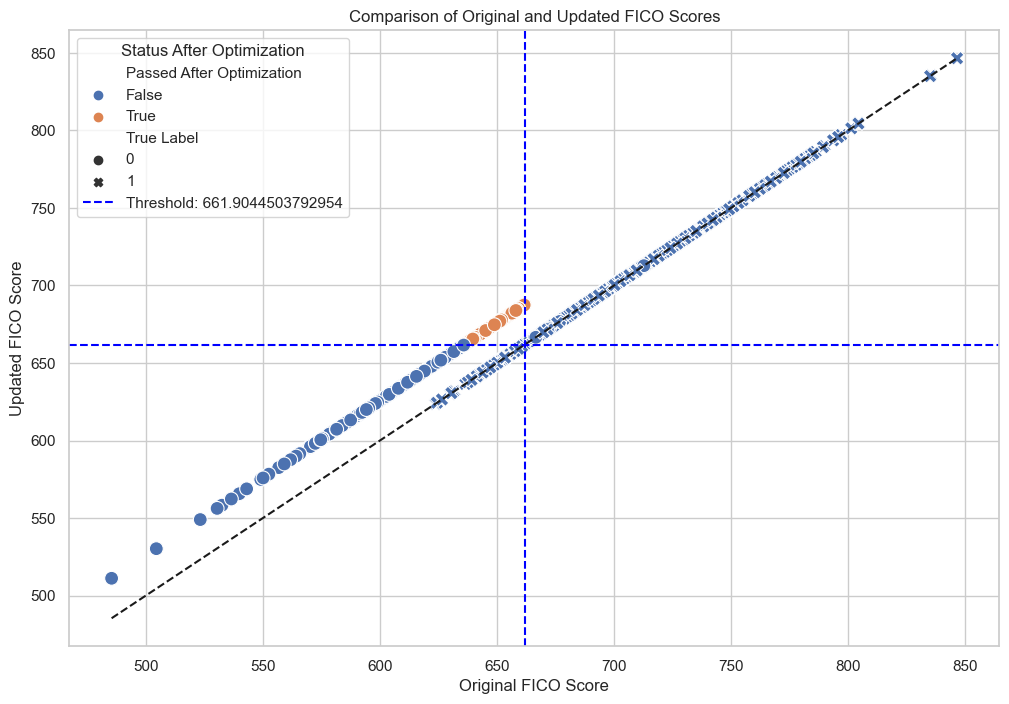

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume threshold_fico_score is defined as per your model output
threshold_fico_score = score_at_threshold

# Determine which loans have passed the threshold after optimization
fico_df['Passed After Optimization'] = (fico_df['Updated FICO Score'] >= threshold_fico_score) & (fico_df['FICO Score'] < threshold_fico_score)

# Set the style of seaborn plot
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(12, 8))

sns.scatterplot(x=fico_df['FICO Score'], y=fico_df['Updated FICO Score'], hue=fico_df['Passed After Optimization'], style=fico_df['True Label'], s=100)

# plot x=y line
plt.plot([fico_df['FICO Score'].min(), fico_df['FICO Score'].max()], [fico_df['FICO Score'].min(), fico_df['FICO Score'].max()], 'k--')

# Adding reference lines for the threshold
plt.axhline(y=threshold_fico_score, color='blue', linestyle='--', label=f'Threshold: {threshold_fico_score}')
plt.axvline(x=threshold_fico_score, color='blue', linestyle='--')

plt.title('Comparison of Original and Updated FICO Scores')
plt.xlabel('Original FICO Score')
plt.ylabel('Updated FICO Score')
plt.legend(title='Status After Optimization')
plt.show()

In [108]:
fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label,Updated FICO Score,Passed After Optimization
0,785.420205,736.913991,451.749352,692.499783,234.854657,630.693967,0.126684,0,656.469116,False
1,686.173570,719.320818,569.000000,713.000000,736.921118,686.299107,0.974167,1,686.299107,False
2,764.768854,797.272891,849.000000,822.000000,661.986420,782.599608,0.999998,1,782.599608,False
3,832.302986,680.290205,695.000000,731.000000,485.116537,721.254760,0.999196,1,721.254760,False
4,676.584663,816.627977,763.000000,845.000000,648.383035,745.581328,0.999929,1,745.581328,False
5,626.586304,652.577607,749.000000,765.000000,824.186697,686.347158,0.974287,1,686.347158,False
6,857.921282,764.920133,630.000000,844.000000,717.807315,780.429220,0.999998,1,780.429220,False
7,776.743473,504.395331,552.000000,790.000000,649.655303,649.944345,0.498609,1,649.944345,False
8,633.052561,764.917478,584.000000,774.000000,381.189291,654.162569,0.602587,1,654.162569,False
9,704.256004,720.170964,573.000000,600.000000,669.606093,675.451500,0.927247,1,675.451500,False


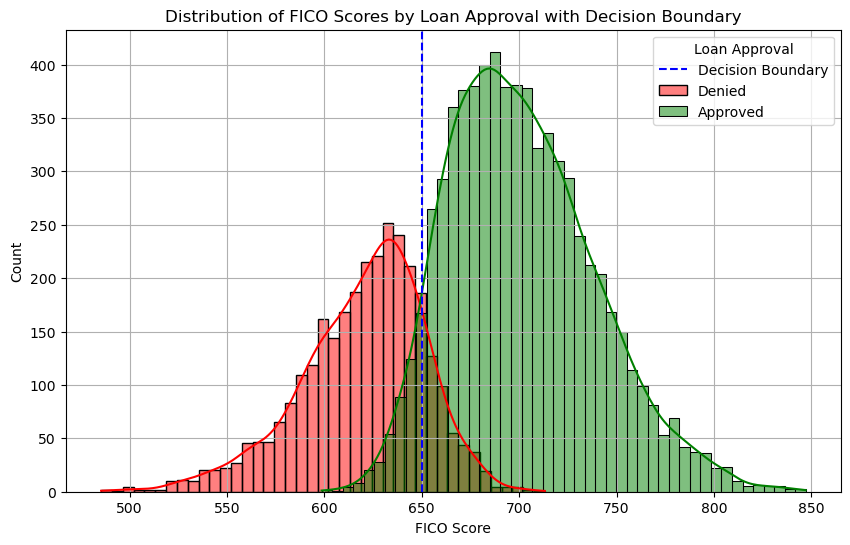

In [19]:
# # A classifier that uses the FICO score to predict loan approval
# def h(x, beta, threshold):
#     return 1 if np.dot(beta, x) >= threshold else 0

# weights = {'Payment History': 0.35, 'Amounts Owed': 0.30, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
# beta = np.array([weight for weight in weights.values()])

# # Calculate the accuracy of the classifier
# fico_df['Predicted Label'] = fico_df.apply(lambda row: h(row[['Payment History', 'Amounts Owed', 'Length of Credit History', 'Credit Mix', 'New Credit']], beta, 650), axis=1)
# accuracy = (fico_df['Predicted Label'] == fico_df['True Label']).mean()
# print(f'Accuracy: {accuracy:.2f}')

# # Plot the distribution of FICO scores for each class and the classifier's decision boundary
# plt.figure(figsize=(10, 6))
# sns.histplot(fico_df[fico_df['True Label'] == 0]['FICO Score'], color='red', label='Denied', kde=True)
# sns.histplot(fico_df[fico_df['True Label'] == 1]['FICO Score'], color='green', label='Approved', kde=True)
# plt.axvline(650, color='blue', linestyle='--', label='Decision Boundary')
# plt.title('Distribution of FICO Scores by Loan Approval with Decision Boundary')
# plt.xlabel('FICO Score')
# plt.ylabel('Count')
# plt.legend(title='Loan Approval')
# plt.grid(True)
# plt.show()


In [6]:
# fico_df.head()
# # drop the predicted label column and store the data in a new dataframe


,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label,Predicted Label
0,749.671415,706.285266,690,670,741.096754,718.880251,0.998981,1,1
1,686.173570,568.537433,624,685,719.431848,644.765164,0.372038,1,0
2,764.768854,782.821399,559,609,535.475954,700.813114,0.993827,1,1
3,852.302986,779.838422,500,609,774.948796,745.652451,0.999930,1,1
4,676.584663,802.699392,848,638,781.528487,746.767298,0.999937,1,1


In [77]:
# # Cost function for changing feature profiles
# def c(x, x_0, cost_coefficient=1):
#     return cost_coefficient * np.linalg.norm(x - x_0)

